<a href="https://colab.research.google.com/github/Estrellas-857/IDS703NLP_Final_Project/blob/main/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This model is for data after pre-posscessing**

import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import chardet
from google.colab import drive
from google.colab import files
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt


load file from google drive and read

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ids703nlp/IMDB Dataset_cleaned.csv'
!ls "/content/drive/My Drive/ids703nlp"

# detect the file encoding format
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read(100000))  # read the file partially
    print(result)

# use the detected encoding format to read the file
df = pd.read_csv(file_path, encoding=result['encoding'])

df.head()

Mounted at /content/drive
 data_cleaning.ipynb			 real-data-Evaluated.png
' Discriminative Neural Network.ipynb'	 reference.gdoc
'IMDB Dataset_cleaned.csv'		 report.gdoc
 IMDB_Dataset.csv			 synthetic_data.csv
 mathematical_probability_model.ipynb	 synthetic-data-Evaluated.png
 naive_bayes.ipynb
{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


,Unnamed: 0,review,sentiment,review_cleaned
0,0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,1,A wonderful little production. <br /><br />The...,positive,wonderful little production. filming technique...
2,2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


from the above display, we can see that the original file now has 4 columns after the data cleaning work. We shall use the cleaned review and its tag.

In [ ]:
# load the data
data = pd.read_csv(file_path)

def nb_model(data):
  # devide the dataset into train set(80%) and test set(20%)
  X_train, X_test, y_train, y_test = train_test_split(data['review_cleaned'], data['sentiment'], test_size=0.2, random_state=42)

  # Feature Extraction - Bag of Words Model
  vectorizer = CountVectorizer()
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  # create a naive bayes classifier
  nb_classifier = MultinomialNB()
  nb_classifier.fit(X_train_vec, y_train)

  # predict the test set
  y_pred = nb_classifier.predict(X_test_vec)

  # Separate correctly and incorrectly classified samples
  correct_classified = X_test[y_test == y_pred]
  incorrectly_classified = X_test[y_test != y_pred]

  # Find misclassified samples
  #errors = data.loc[(X_test.index, 'review_cleaned')][(y_test != y_pred)]
  #errors.to_csv('classification_errors.csv', header=True)

  # Get feature name (vocabulary)
  feature_names = vectorizer.get_feature_names_out()

  # Get the weight of each feature
  pos_class_prob_sorted = nb_classifier.feature_log_prob_[1, :].argsort()
  neg_class_prob_sorted = nb_classifier.feature_log_prob_[0, :].argsort()

  # Print the features with the highest weight (top 10)
  print("Words most indicative of positive reviews:")
  for i in pos_class_prob_sorted[-10:]:
      print(feature_names[i])

  print("\nWords most indicative of negative reviews:")
  for i in neg_class_prob_sorted[-10:]:
      print(feature_names[i])

  # Evaluate model performance
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))

  return correct_classified, incorrectly_classified

#nb_model(data)

Evaluate the probabilistic model on real data qualitatively
and quantitatively.

Words most indicative of positive reviews:
well
great
story
would
good
like
one
movie
film
not

Words most indicative of negative reviews:
time
good
bad
even
would
like
one
film
movie
not
Accuracy: 0.8598

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.88      0.86      4961
    positive       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



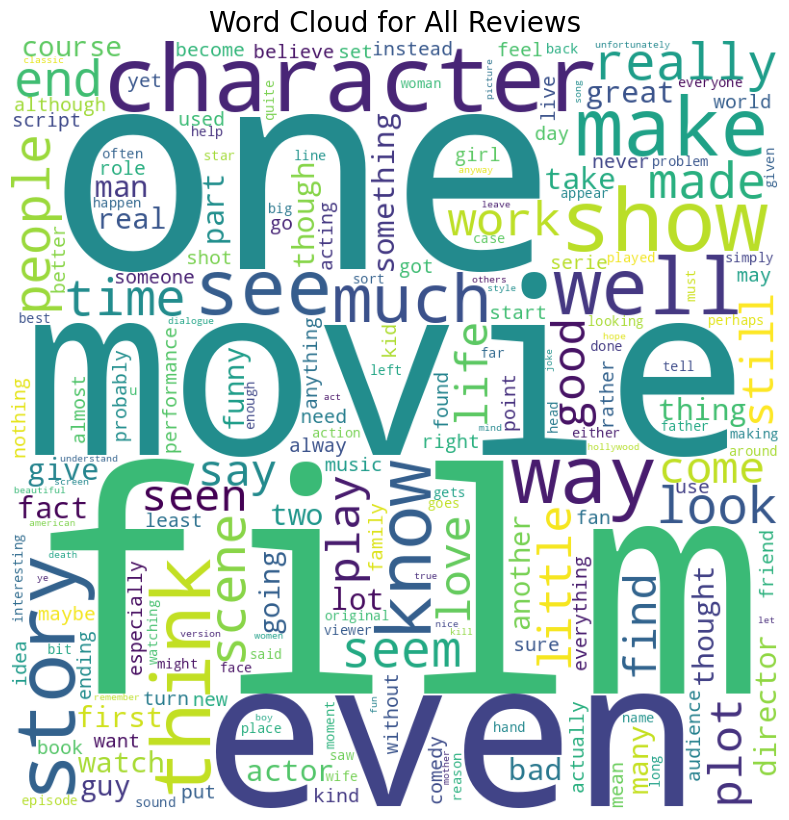

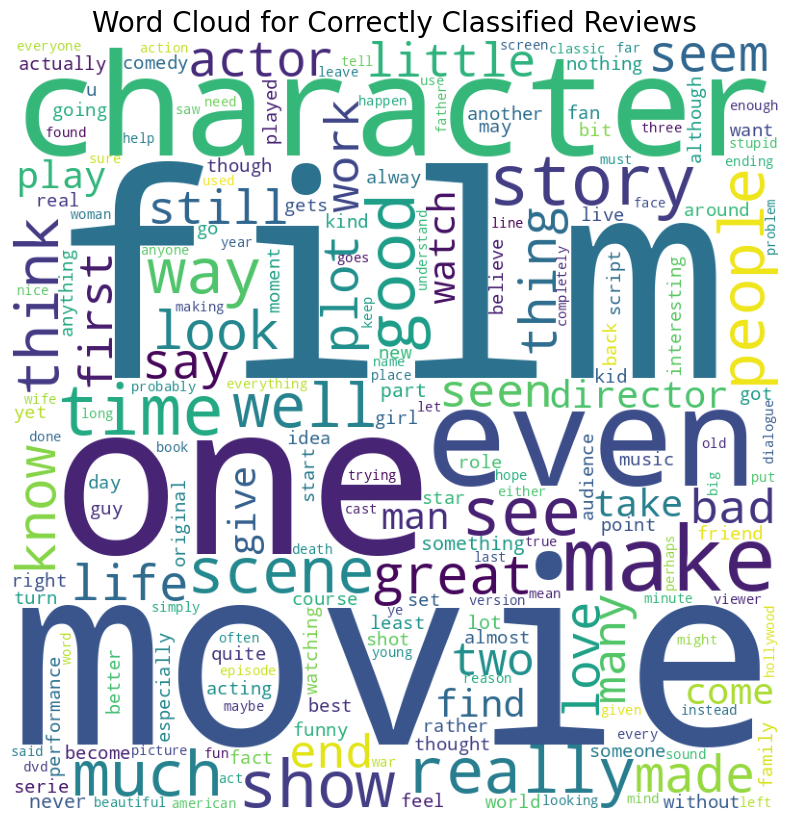

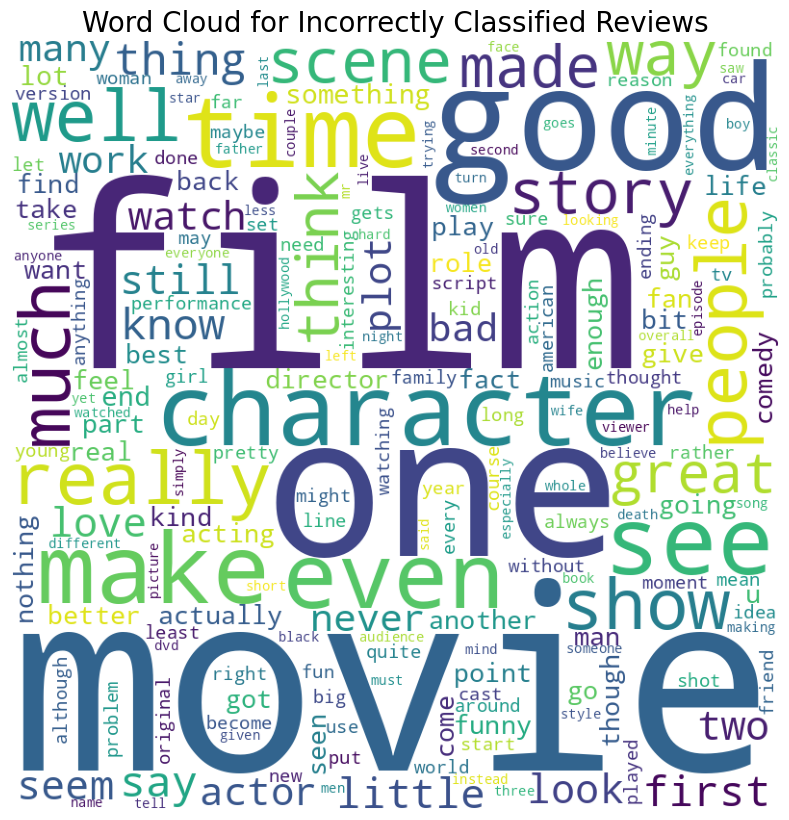

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          min_font_size=10).generate(text)

    # Draw word cloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()

# Combine all comments into one big string
real_data_reviews = ' '.join(data['review_cleaned'])

correct_real_samples, incorrect_real_samples = nb_model(data)

# Call the nb_model function and get the misclassified samples
#_, real_data_classification_errors = nb_model(data)

# Generate word cloud
generate_wordcloud(real_data_reviews, "Word Cloud for All Reviews")

# Generate a word cloud of correctly classified samples
generate_wordcloud(' '.join(correct_real_samples), "Word Cloud for Correctly Classified Reviews")

# Generate word cloud of misclassified samples
generate_wordcloud(' '.join(incorrect_real_samples), "Word Cloud for Incorrectly Classified Reviews")

# Save file to Colab virtual machine
incorrect_real_samples.to_csv('real_data_classification_errors.csv')

# Download file to local computer
files.download('real_data_classification_errors.csv')

After testing the naive bayes model, use markov text generator to generate synthetic data.

In [ ]:
### Markov Text Generation Model

# load the data
data = pd.read_csv(file_path)

# This function receives a data set containing movie reviews.
# It classifies movie reviews by sentiment (positive or negative) and performs word segmentation on each review.
# Finally, a list of words classified by sentiment is returned.训练数据
def preprocess_data(data, order):
    data_by_sentiment = defaultdict(list)
    for _, row in data.iterrows():
        # Add the appropriate number of opening and closing tags to each comment
        tokens = ['<start>']*order + row['review_cleaned'].lower().split() + ['<end>']
        data_by_sentiment[row['sentiment']].append(tokens)
    return data_by_sentiment

# This function creates a Markov chain from preprocessed data.
# It creates a dictionary for each emotion category, where the key is the current word and the value is a dictionary that records the number of occurrences of the next possible word.
# The chain thus constructed captures the sequential relationship in which words appear in the text.
# Construct a Markov chain with adjustable order
def build_markov_chain(data_by_sentiment, order):
    markov_chain = {}
    for sentiment, reviews in data_by_sentiment.items():
        chain = defaultdict(lambda: defaultdict(int))
        for review in reviews:
            for i in range(len(review) - order):
                # Create a tuple containing the current word and the previous words
                state = tuple(review[i:i+order])
                next_word = review[i + order]
                chain[state][next_word] += 1
        markov_chain[sentiment] = chain
    return markov_chain

# This function is used to generate movie reviews.
# It first randomly selects a starting word and then selects the next word based on a Markov chain.
# This process repeats until the specified length is reached or there is no next word to choose from.
# The generated text is a movie review composed of selected word sequences.
def generate_review(chain, sentiment, order, length=50):
    review = []
    state = random.choice(list(chain[sentiment].keys()))
    review.extend(state)

    for _ in range(length - order):
        next_words = list(chain[sentiment][state].keys())
        if not next_words:
            break
        next_word = random.choice(next_words)
        review.append(next_word)
        # Update status, remove the oldest word, add the latest word
        state = state[1:] + (next_word,)

    # Remove the start marker and stop when the end marker is reached
    review = [word for word in review if word != '<start>']
    if '<end>' in review:
        review = review[:review.index('<end>')]

    return ' '.join(review)

# order = 2  # This value can be adjusted to change the order of the Markov chain
# If the value of order is not specified, set the default value to 1
if 'order' not in locals():
    order = 1

# process data
data_by_sentiment = preprocess_data(data, order)
markov_chain = build_markov_chain(data_by_sentiment, order)

# generate a pos review
print("Positive review:")
print(generate_review(markov_chain, 'positive', order))

# generate a neg review
print("\nNegative review:")
print(generate_review(markov_chain, 'negative', order))

Positive review:
future.contrary others princess eloise school tries tie chair. soon lose excepts would posed really serious except top bridge! guys pre seinfeld everyone house flipping cable company exec jim bacchus others stunning graphics look natural wigs daft rather impressed production mame came following inspiration. think humorous voyage fun see. mind twists

Negative review:
basiaclly violence talking sexual chemistry work various detritus left large leaps balcony scene creepazoid jesse stalking skipper boat plane hijacking mobile pieces carpeting. work classical score vampire well flick action. war drones stalking totally spy survives. nearby greek television regulars shatner art cover air drop chemical breached. man remainder weekend.do


Combine Markov and Naive Bayes together for the synthetic data test.

In [ ]:
# 'generate_markov_review' is a function used by the Markov model to generate movie reviews
# 'data' is the original movie review data set
# 'markov_data' is the generated synthetic data set

# build synthetic data
num_samples = 50000  # total dataset number

# make sure num_samples is even
if num_samples % 2 != 0:
    num_samples += 1

markov_reviews = [generate_review(markov_chain, sentiment, order) for sentiment in ['positive', 'negative'] for _ in range(num_samples//2)] # equally devided by 2
markov_sentiments = ['positive'] * (num_samples//2) + ['negative'] * (num_samples//2)
markov_data = pd.DataFrame({'review_cleaned': markov_reviews, 'sentiment': markov_sentiments})

# combine 2 datasets (pos and neg)
#combined_data = pd.concat([data, markov_data]).reset_index(drop=True)

#nb_model(combined_data)

In [ ]:
markov_data.to_csv('/content/drive/MyDrive/synthetic_data.csv')

Evaluate the results qualitatively
and quantitatively.

Words most indicative of positive reviews:
would
story
like
well
also
the
one
movie
film
not

Words most indicative of negative reviews:
story
bad
even
like
would
the
one
film
movie
not
Accuracy: 0.9171

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.93      0.92      4978
    positive       0.93      0.91      0.92      5022

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



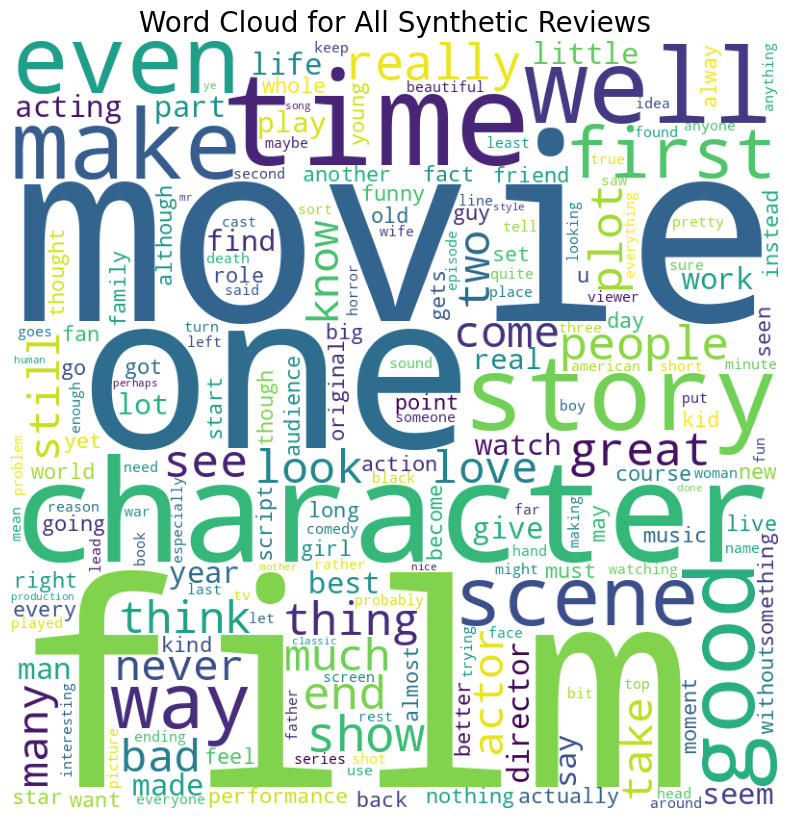

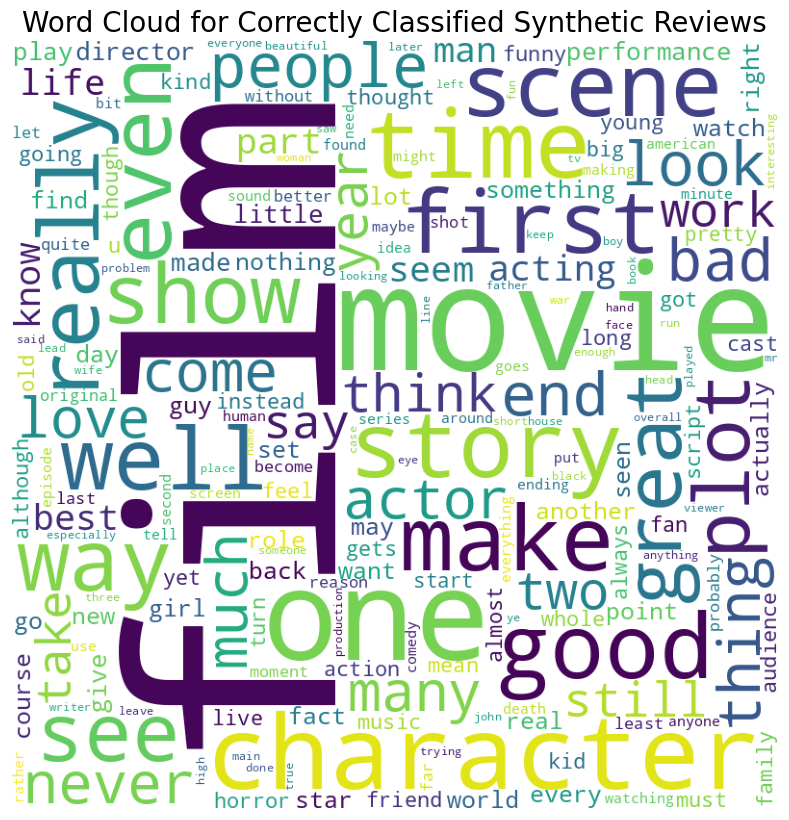

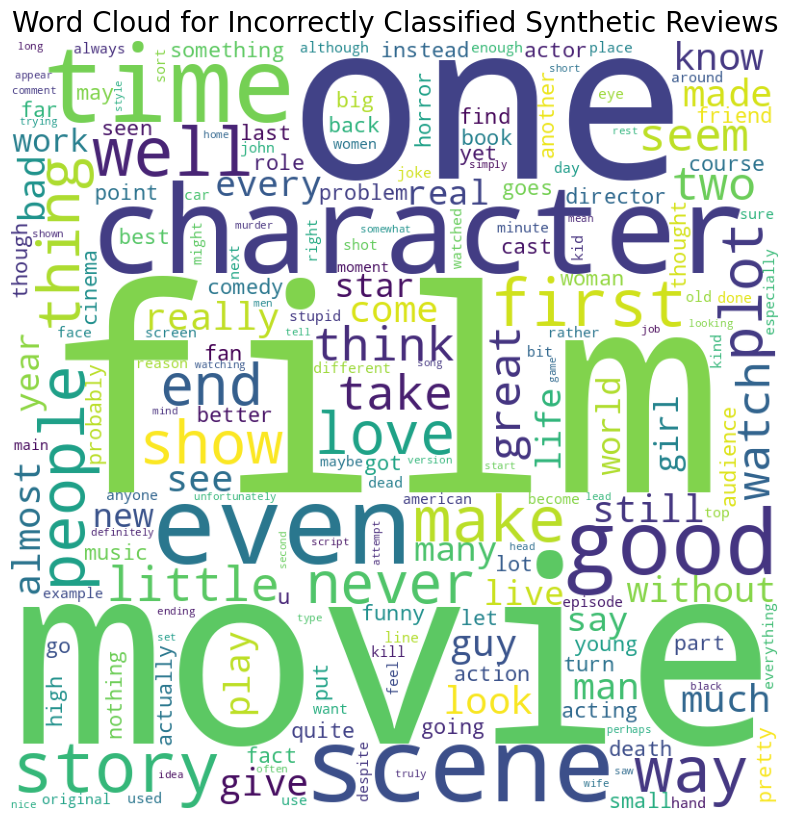

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
synthetic_data_reviews = ' '.join(markov_data['review_cleaned']) # for synthetic data

correct_fake_samples, incorrect_fake_samples = nb_model(markov_data)

# Generate word cloud
generate_wordcloud(synthetic_data_reviews, "Word Cloud for All Synthetic Reviews")

# Generate a word cloud of correctly classified samples
generate_wordcloud(' '.join(correct_fake_samples), "Word Cloud for Correctly Classified Synthetic Reviews")

# Generate word cloud of misclassified samples
generate_wordcloud(' '.join(incorrect_fake_samples), "Word Cloud for Incorrectly Classified Synthetic Reviews")

# Save file to Colab virtual machine
incorrect_fake_samples.to_csv('synthetic_data_classification_errors.csv')

# Download file to local computer
files.download('synthetic_data_classification_errors.csv')



Basically we can analys all the result from the above given-info.